# Super organised modular notebook


## Imports and installation

You can install the packages needed using the following command `pip install -r requirements.txt`  where the file contains the following:

<div class="alert alert-block alert-info">

aiohttp==3.9.5\
asyncio==3.4.3\
igraph\
requests\
py4cytoscape==1.9.0\
pandas\
tqdm==4.66.2\
numpy\
matplotlib\
nest_asyncio\
jsonpath-ng\
ruamel.yaml\
cwl_utils
</div>

Please note that Cytoscape has to be installed and open on your machine for visualisation to work.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import nest_asyncio         # For jupyter asyncio compatibility 
nest_asyncio.apply()        # Automatically takes into account how jupyter handles running event loops
from datetime import datetime
import igraph              
import py4cytoscape as p4c  # Cytoscape for visualisation of the citaton graph, 
                            # note that Cytoscape has to be installed and open on your machine for visualisation to work

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), 'src')))

import WFQC.data
from WFQC.network import create_citation_network 
from WFQC.workflow import parse_workflows, radnomise_workflows
from WFQC.metrics import sum_metric, path_metric

Check that the packages are installed and functional 

In [3]:
print("igraph version:", igraph.__version__) #TODO: sometimes this runs forever when it does not find cytoscape, sometimes not. check why
try: 
    dir(p4c)
    p4c.cytoscape_ping()    
    print("Cytoscape version:",p4c.cytoscape_version_info()['cytoscapeVersion'])    
except:
    print ("Make sure to have Cytoscape installed and open (or don't, if you don't care about the visualisation)!")

igraph version: 0.11.5
You are connected to Cytoscape!
Cytoscape version: 3.10.2


## Downloading data 

Looking at the documentatio of the imported functions to see everythign is working as intended 

In [4]:
help(WFQC.data)

Help on module WFQC.data in WFQC:

NAME
    WFQC.data - Functions to download data.

FUNCTIONS
    async aggregate_requests(session, url)
        Sync the bio.tools (page) requests so they are all made in a single session 
        
        Parameters
        ----------
        session : aiohttp.client.ClientSession object
            session object for package aiohttp
        url : str
            url for request
    
    europepmc(article_id, format='JSON', source='MED', page=1, page_size=1000)
        Downloads pmids for the articles citing the given article_id, returns list of citation pmids (PubMed IDs)
            
        Parameters
        ----------
        article_id : str # TODO: int? 
            pmid, PubMed ID, for a given article.
        source: str
            source ID as given by the EuropePMC API documentation: https://europepmc.org/Help#contentsources 
        
        page, int, default == 1
            determines where to start looking TODO: remove this, why would

## Graph generation

In [5]:
help(create_citation_network)

Help on function create_citation_network in module WFQC.network:

create_citation_network(topicID='topic_0121', testSize='', randomSeed=42, loadData=True, filePath='', outpath=None, inpath='', saveFiles=True, includeCitationNodes=False)
    Creates a citation network given a topic and returns a graph and the tools included in the graph
    
        
    Parameters
    ----------
    topicID : str, default "topic_0121" (proteomics) TODO: int? 
        The ID to which the tools belongs to, ex. "Proteomics" or "DNA" as defined by 
        EDAM ontology (visualisation: https://edamontology.github.io/edam-browser/#topic_0003)
    
    testSize : int or None, default None
        Determines the number of tools included in the citation graph.
    
    randomSeed : int, default 42
        Specifies what seed is used to randomly pick tools in a test run. 
    
    loadData : Boolean, default True
        Determines if already generated graph is loaded or if it is recreated.
    
    filePath : 

The function create_citation_network can be called to create or load the cocitation network

### Load data

In [6]:
#TODO: filepath for input files! - change bio.tools thing 

path_to_data = 'data/out_202405211310'

G, included_tools = create_citation_network(inpath=path_to_data) # TODO: if no data then make data or ask if make data?


Loading saved data.


### Generate new graph


#### Test size

For example with a testsize of 10 tools

In [ ]:
G, included_tools = create_citation_network(loadData=False, testSize=20) 

Or with the citation nodes included

In [ ]:
G, included_tools = create_citation_network(loadData=False, testSize=20, includeCitationNodes=True) 

Bio.tools data loaded from existing CSV file.
Creating test-cocitation network of size 20. Random seed is 42.


Processing PMIDs: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]

Creating citation graph using igraph.
1024 unique out of 1024 edges total!
Removing citations with degree less or equal to 1 (Non co-citations).
Number of vertices removed with threshold 20: 0
Saving data to directory out_202405241511.


#### Full network

Or the entire bio.tools database proteomics topic (default), or another specified topic:

In [ ]:
G, included_tools = create_citation_network(loadData=False) #again

Lets check what attributes the co-citation graph has, and that the it was correctly generated

In [8]:
graph_attributes = G.vs.attributes()
print("Graph-level attributes:", graph_attributes)

edge_attributes = G.es.attributes()
print("Edge-level attributes:", edge_attributes)


print('Tools in graph: ', len(included_tools))

if len(np.sort(G.vs['name'])) ==len(np.sort(included_tools)):
    diff=set(included_tools) -set(included_tools).intersection(set(G.vs['name']))
    print(diff)

Graph-level attributes: ['name']
Edge-level attributes: ['weight']
Tools in graph:  1104


## The metric

### Download workflow data


<div class="alert alert-block alert-warning">
<b>OBS:</b> This is not yet implemented. Currently drawing random tools to simulate workflows
</div>

Test that loading one workflow works

In [ ]:
cwl_file = "./workflows/candidate_workflow_2.cwl"
cvsfile = 'biotools_metadata_topic_0121_20240516.csv' #TODO: Hardcoded?

workflow_pairs, workflow_tools = parse_workflows(cwl_file,cvsfile) # TODO: more than one at a time 

rand_workflow_pairs, rand_workflow_tools = radnomise_workflows(included_tools, num_pairs = 3)

print(workflow_pairs, rand_workflow_pairs)

[('23051804', '23148064'), ('14632076', '23051804')] [('31532487', '33827920'), ('18724940', '32786689'), ('36899918', '23385215')]


could add visualisation of the workflows and the original workflows. 

### Calculate metric

<div class="alert alert-block alert-warning">
<b>OBS:</b> This is a simple placeholder implementation of a metric
</div>

Test that calculating the metric for one workflow works

In [ ]:
# For one workflow
metric_score, raw_results = comet(G, workflow_pairs)

print(raw_results)

print(f"Total cocitation score for workflow {workflow_pairs} is {metric_score}.")


[55, 22]
Total cocitation score for workflow [('23051804', '23148064'), ('14632076', '23051804')] is 38.5.


### Evaluate results 

Below I am comparing the workflows from workflomics, to completely randomly drawn tools from the bioinformatics topic 

In [ ]:
workflomics_tools = {"Comet":"23148064" , "PeptideProphet":"12403597" ,"ProteinProphet":"14632076" ,"StPeter":"29400476" ,"mzRecal":"33538780" ,
                     "idconvert":"23051804" ,"msconvert":"23051804" ,"GOEnrichment":None ,"gProfiler":'27098042' ,"ms_amanda":'24909410' ,
                       "msfragger":'28394336' , "protXml2IdList":None }
# some of them do not have 

In [ ]:
workflows = []
rand_workflows = []

#TODO: make this a function?
for i in range(1, 25):
    cwl_file = f"./workflows/candidate_workflow_{i}.cwl" #TODO: customise path!!
    try:
        workflow_pairs, workflow_tools = parse_workflows(cwl_file,cvsfile) # TODO: more than one at a time 
        workflows.append(workflow_pairs)

        rand_workflow_pairs, rand_workflow_tools = radnomise_workflows(included_tools, num_pairs = len(workflow_tools)) # making sure they all have the same amount of tools 
        rand_workflows.append(rand_workflow_pairs)
    except:
        print("no", cwl_file)
        continue 


print(workflows, rand_workflows) # wooh thats ineffeicient 

no ./workflows/candidate_workflow_8.cwl
no ./workflows/candidate_workflow_9.cwl
no ./workflows/candidate_workflow_18.cwl
no ./workflows/candidate_workflow_19.cwl
[[('14632076', '12403597'), ('12403597', '14976030')], [('23051804', '23148064'), ('14632076', '23051804')], [('12403597', '23148064'), ('14632076', '12403597')], [('29400476', '23148064'), ('14632076', '23148064'), ('29400476', '14632076')], [('29400476', '14976030'), ('29400476', '14632076'), ('14632076', '14976030')], [('29400476', '23148064'), ('14632076', '23148064'), ('29400476', '14632076')], [('33538780', '23148064'), ('14632076', '14976030'), ('14976030', '33538780')], [('29400476', '23148064'), ('14632076', '23148064'), ('29400476', '33538780'), ('29400476', '14632076'), ('33538780', '23148064')], [('12403597', '23148064'), ('29400476', '14632076'), ('29400476', '12403597'), ('14632076', '23148064')], [('14632076', '23148064'), ('29400476', '14632076'), ('29400476', '14976030')], [('14632076', '12403597'), ('12403597

The workflow directory does not contain WF 8, 9, 18 and 19. So there should be 20, let's check:

In [ ]:
print(len(workflows), len( rand_workflows))

20 20


In [ ]:
scores=[]
rand_scores =[]

for i in range(len(workflows)):
    metric_score, raw_results = comet(G, workflows[i])
    rand_metric_score, rand_raw_results = comet(G, rand_workflows[i])

    scores.append(metric_score)
    rand_scores.append(rand_metric_score)
    
print(rand_scores, scores)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [289.5, 38.5, 323.5, 27.0, 18.333333333333332, 27.0, 16.0, 16.4, 58.0, 26.0, 196.66666666666666, 162.25, 23.666666666666668, 19.333333333333332, 27.0, 18.333333333333332, 19.333333333333332, 26.0, 18.333333333333332, 35.25]


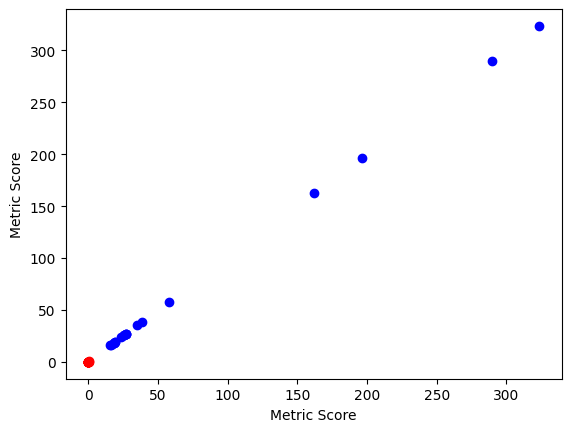

In [ ]:

plt.scatter(scores, scores, color='blue', label='Non-random')
plt.scatter(rand_scores, rand_scores, color='red', label='Random')

plt.xlabel('Metric Score')
plt.ylabel('Metric Score')
plt.show()


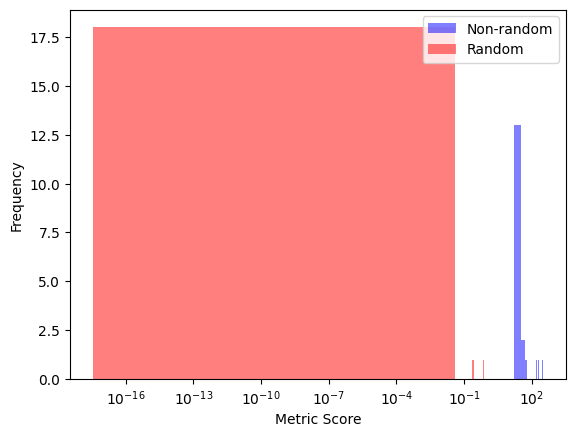

In [ ]:

fig, ax = plt.subplots()

ax.hist(scores, bins=20, color='blue', alpha=0.5, label='Non-random')

ax.hist(rand_scores, bins=20, color='red', alpha=0.5, label='Random')

ax.set_xlabel('Metric Score')
ax.set_ylabel('Frequency')
ax.legend()

ax.set_xscale('log') # because otherwise not showing up in same plot for some reason

# Show plot
plt.show()


Obviously this comparison is not very fair and we should make sure that the "functional workflows" are drawn from the same set as the randoms, whereas now they are drawn from a very small subset of very well annotated tools. This is more to show that the comparison works, not that the results are reliable. 

## Visualisation


Using cytoscape to visualise the network

In [9]:

current_time = datetime.now().strftime("%Y%m%d%H%M")

p4c.create_network_from_igraph(G, f"Cocitations_Size{len(included_tools)}_{current_time}", collection="Citation networks")

# edge_attributes = p4c.get_table_columns(table='edge', columns=['weight'])
# weights = edge_attributes['weight']

Applying default style...
Applying preferred layout


346802

In [ ]:
print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)
p4c.set_node_color_bypass(included_tools, "#FF0000")  # Red color in hexadecimal
p4c.set_node_size_bypass(included_tools, 100)  # remember it cannot be a np.array, just a list argh 

In [ ]:
# Styling edges
p4c.set_edge_label_mapping('weight')
p4c.set_edge_line_width_mapping(**p4c.gen_edge_width_map('weight', mapping_type='c'))